In [82]:
# Import necessary libraries
import os
import re
import string


import gensim
import spacy
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer


import matplotlib.pyplot as plt
import seaborn as sns

### A) Data import and small pre-processing

In [83]:
## import data

df_droite_T1 = pd.read_csv('Articles/articles_extraits_T1_droite.csv') # data from codes_data_formating
df_gauche_T1 = pd.read_csv('Articles/articles_extraits_T1_gauche.csv')
df_centre_T1 = pd.read_csv('Articles/articles_extraits_T1_centre.csv')
df_droite_T2 = pd.read_csv('Articles/articles_extraits_T2_droite.csv')
df_gauche_T2 = pd.read_csv('Articles/articles_extraits_T2_gauche.csv')
df_centre_T2 = pd.read_csv('Articles/articles_extraits_T2_centre.csv')

df_droite= pd.concat([df_droite_T1, df_droite_T2], axis=0) # Concatenate T1 and T2 on political orientation
df_droite['orientation'] = 'Right'
df_gauche= pd.concat([df_gauche_T1, df_gauche_T2], axis=0)
df_gauche['orientation'] = 'Left'
df_centre=pd.concat([df_centre_T1, df_centre_T2], axis=0)
df_centre['orientation'] = 'centre'

df_total= pd.concat([df_droite, df_gauche, df_centre], axis=0) 
df_total['contenu'].fillna(df_total['contenu'],inplace=True)


In [86]:
len(df_droite)

202

In [ ]:
#small pre-processing function to remove copyright and other irrelevant information from the text
def couper_apres_copyright(texte):
    if "Copyright 2024" in texte:
        return texte.split("Copyright 2024", 1)[1]
    else:
        return texte  # Si "Copyright 2024" n'est pas présent, on laisse tel quel
    
df_total['contenu'] = df_total['contenu'].apply(couper_apres_copyright)
df_gauche['contenu'] = df_gauche['contenu'].apply(couper_apres_copyright)
df_droite['contenu'] = df_droite['contenu'].apply(couper_apres_copyright)
df_centre['contenu'] = df_centre['contenu'].apply(couper_apres_copyright)
df_total 

In [57]:
journal_type = {
    'ECHOS': 'quotidien', #quotidien de droite
    'EXPRSS': 'hebdomadaire',  # L'Express est un hebdomadaire
    'FIGARO': 'quotidien', #quotidien de droite
    'HUMAN': 'quotidien', #quotidien de gauche
    'LACRX': 'hebdomadaire', # hebdomadaire du centre
    'LBRT': 'quotidien', #quotidien de gauche
    'LENOV': 'hebdomadaire', #hebdomadaire de gauche
    'LPOINT': 'hebdomadaire', #hebdomadaire de droite
    'MARIAN': 'hebdomadaire', # hebdomadaire de gauche 
    'TRDS': 'hebdomadaire', # la tribune hebdo du centre
    'TSONL': 'quotidien'# quoditien du centre
}
df_total['type_journal'] = df_total['nom_journal'].map(journal_type) # ajouter le type de journal quotidien ou hebdomadaire
df_droite['type_journal'] = df_droite['nom_journal'].map(journal_type) # ajouter le type de journal quotidien ou hebdomadaire
df_gauche['type_journal'] = df_gauche['nom_journal'].map(journal_type) # ajouter le type de journal quotidien ou hebdomadaire   
df_centre['type_journal'] = df_centre['nom_journal'].map(journal_type) # ajouter le type de journal quotidien ou hebdomadaire   



### B) Word count

### C)TOP 500

In [192]:
df_total=df_centre # si l'on veut restreindre l'étude

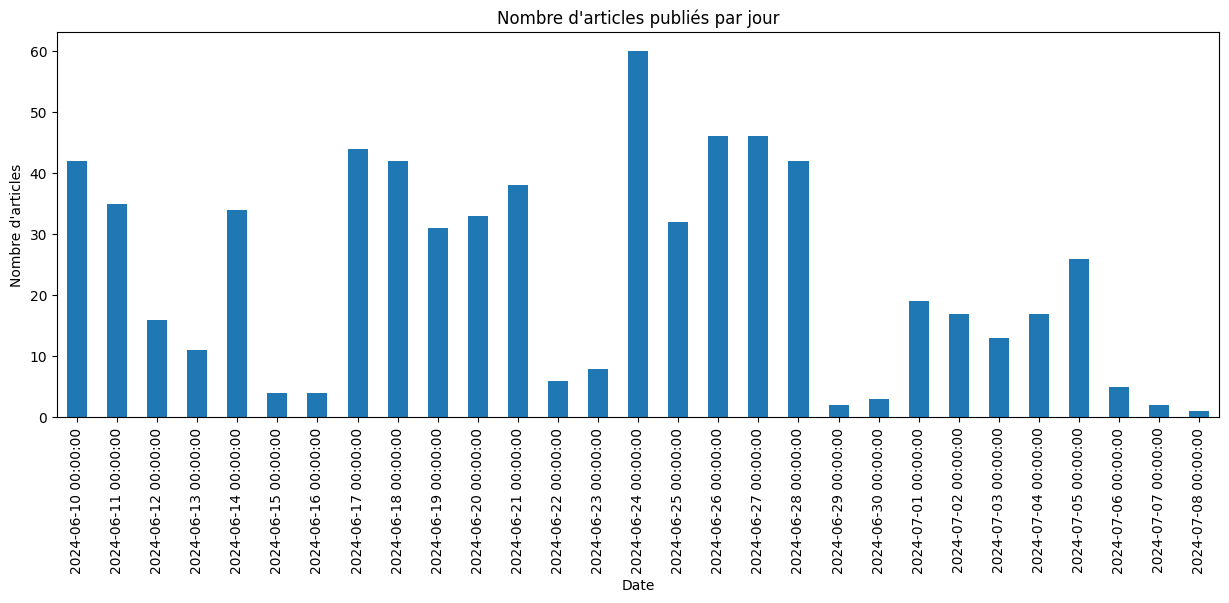

In [ ]:




# 1. Conversion en datetime
df_total['date'] = pd.to_datetime(df_total['date'], format="%d/%m/%Y") 

articles_par_jour = df_total.groupby('date').size()

# 3. Afficher un histogramme
plt.figure(figsize=(15,5))
articles_par_jour.plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Nombre d\'articles')
plt.title('Nombre d\'articles publiés par jour')
plt.xticks(rotation=90)
plt.show()


In [194]:
nlp = spacy.load("fr_core_news_sm") # instanciation de spacy pour le français
documents_nlp = []
for d in tqdm(nlp.pipe(df_total["contenu"],n_process=1),total=len(df_total["contenu"])): # tokenize tout le contenu
    documents_nlp.append(d)
len(documents_nlp) == len(df_total) 


100%|██████████| 679/679 [02:33<00:00,  4.41it/s] 


True

In [188]:
nlp_doc=documents_nlp[15] #Pour un document exemple

for token in nlp_doc[:50]:
    print (token,'->',token.pos_) # vérifie si fonctionne convenablement en français

    ## count nouns and GPEs
N_nouns = 0
N_verbs = 0
GPEs = []
Nouns = []
Verbs = []
for token in nlp_doc:
    if token.pos_ == "NOUN":
        Nouns.append(token.text)
    elif token.pos_ == "VERB":
        Verbs.append(token.text)



  -> SPACE
Le -> DET
Figaro -> PROPN
. -> PUNCT

 -> SPACE
Le -> DET
sévère -> ADJ
revers -> ADJ
encaissé -> VERB
par -> ADP
la -> DET
liste -> NOUN
de -> ADP
Valérie -> PROPN
Hayer -> PROPN
handicape -> VERB
le -> DET
président -> NOUN
, -> PUNCT
le -> DET
poussant -> NOUN
à -> ADP
prendre -> VERB
la -> DET

 -> SPACE
parole -> NOUN
. -> PUNCT

 -> SPACE
Le -> DET
problème -> NOUN
, -> PUNCT
c' -> PRON
est -> VERB
qu' -> ADV
autour -> ADV
de -> ADP
Macron -> PROPN
, -> PUNCT
ils -> PRON
n' -> ADV
ont -> AUX
pas -> ADV
appris -> VERB
à -> ADP
perdre -> VERB
... -> PUNCT
  -> SPACE
» -> PUNCT
Cette -> DET
phrase -> NOUN


In [195]:
# sur tous le dataset

def return_nouns_verbs_adjectives(nlpdoc):
    ## define a nounlist
    l_noun = []
    l_adjectives=[]
    l_verbs=[]
    for token in nlpdoc:
        if token.pos_ == 'NOUN':
             l_noun.append(token.lemma_)
        if token.pos_ == 'ADJ':
            l_adjectives.append(token.lemma_)
        if token.pos_ == 'VERB':
            l_verbs.append(token.lemma_)
    return l_noun, l_adjectives, l_verbs


Nouns_list = [] 
Nouns_list_list = []
Adj_list = [] 
Adj_list_list = []
Verbs_list = [] 
Verbs_list_list = []
for nlpdoc in documents_nlp:
    Nouns, adjectives, verbs = return_nouns_verbs_adjectives(nlpdoc)
    Nouns_list.extend(Nouns)
    Nouns_list_list.append(Nouns)
    Adj_list.extend(adjectives) #concatène les listes
    Adj_list_list.append(adjectives) # ajoute une sous-liste
    Verbs_list.extend(verbs)
    Verbs_list_list.append(verbs)

# len(Nouns_list_list) = 1008 on a bien le bon résutlat


In [196]:
# Pour supprimer quelques mots 

list_nouns_to_delete=['rassemblement',"l’","«","-",'»',"c’","lesechos.fr"]
list_adjectives_to_delete=['tout','national',"c’",'«',"l’","-","b",'quel','xx','*']

Nouns_list = [word for word in Nouns_list if word not in list_nouns_to_delete]
Adj_list = [word for word in Adj_list if word not in list_adjectives_to_delete]

Nouns_list_list = [[word for word in sublist if word not in list_nouns_to_delete] for sublist in Nouns_list_list]
Adj_list_list = [[word for word in sublist if word not in list_adjectives_to_delete] for sublist in Adj_list_list]


In [ ]:
from collections import Counter
import pandas as pd

# Pour avoir les mots les plus donnés en termes de nombre afin de les classifier à la main

# 1. Compter les 500 mots les plus fréquents
top_500_adj = Counter(Adj_list).most_common(500)
top_500_nouns = Counter(Nouns_list).most_common(500)

# Liste des mots à retirer (non pertinents)
stop_words = {"populaire", "extrême", "républicain", "socialiste","national"}  # Ajoute tes mots ici

# 3. Nettoyer les adjectifs (enlever les mots interdits)
filtered_top_500_adj = [(word, count) for word, count in top_500_adj if word.lower() not in stop_words]

# 4. Nettoyer les noms (enlever les mots interdits)
filtered_top_500_nouns = [(word, count) for word, count in top_500_nouns if word.lower() not in stop_words]

# 5. Créer des DataFrames
df_adj = pd.DataFrame(filtered_top_500_adj, columns=['adjectif', 'count'])
df_nouns = pd.DataFrame(filtered_top_500_nouns, columns=['nom', 'count'])

# 6. Sauvegarder en CSV
df_adj.to_csv("top_500_adjectifs_centre.csv", index=False, encoding='utf-8')
df_nouns.to_csv("top_500_noms_centre.csv", index=False, encoding='utf-8')

print("✅ Fichiers CSV générés : top_500_adjectifs.csv et top_500_noms.csv")


✅ Fichiers CSV générés : top_500_adjectifs.csv et top_500_noms.csv


#### Plot

In [170]:
df_total_augmented = df_total.copy()

# On ajoute les listes de mots extraites
df_total_augmented['nouns'] = Nouns_list_list
df_total_augmented['adjectives'] = Adj_list_list
df_total_augmented['verbs'] = Verbs_list_list

# -----------------------------------
# Traitement pour les NOUNS
mlb_nouns = MultiLabelBinarizer()
expandedLabelData_nouns = mlb_nouns.fit_transform(df_total_augmented["nouns"])
labelClasses_nouns = mlb_nouns.classes_
expandedLabels_nouns = pd.DataFrame(expandedLabelData_nouns, columns=labelClasses_nouns)
expandedLabels_nouns = expandedLabels_nouns.applymap(lambda x: re.sub(r"^l'|['\"«»]", "", x) if isinstance(x, str) else x) # enlever les guillemets et les l'


# -----------------------------------
# Traitement pour les ADJECTIVES
mlb_adjectives = MultiLabelBinarizer()
expandedLabelData_adjectives = mlb_adjectives.fit_transform(df_total_augmented["adjectives"])
labelClasses_adjectives = mlb_adjectives.classes_
expandedLabels_adjectives = pd.DataFrame(expandedLabelData_adjectives, columns=labelClasses_adjectives)

# -----------------------------------
# Traitement pour les VERBS
mlb_verbs = MultiLabelBinarizer()
expandedLabelData_verbs = mlb_verbs.fit_transform(df_total_augmented["verbs"])
labelClasses_verbs = mlb_verbs.classes_
expandedLabels_verbs = pd.DataFrame(expandedLabelData_verbs, columns=labelClasses_verbs)



C:\Users\ridea\AppData\Local\Temp\ipykernel_28616\2306737134.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).resample("3D").sum() # au cas où la date est sous le format dd/mm/yyyu


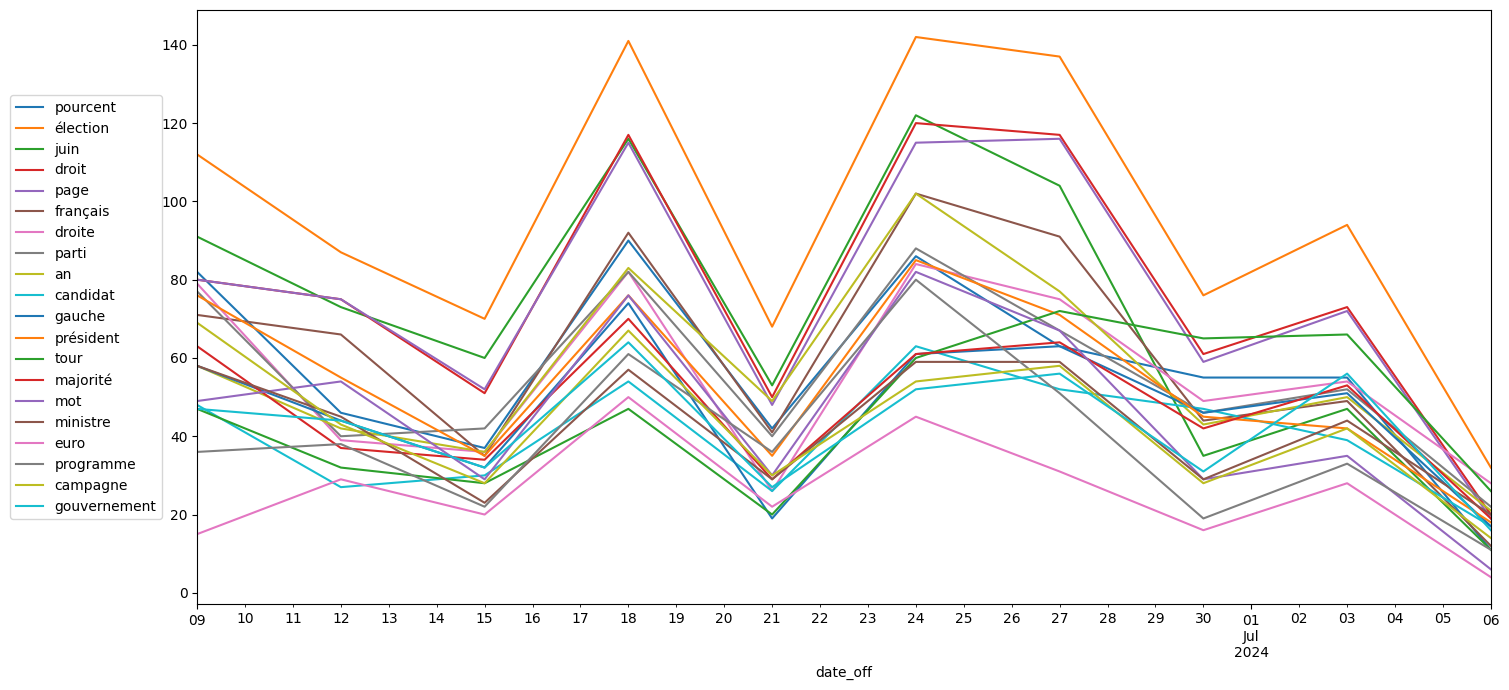

In [217]:
## Sur les noms
df_total_augmented = df_total_augmented.rename(columns={'date': 'date_off'}) # car "date" est rajoutée ensuite en colonne car un nom des expandedLabels...

concat_nouns = pd.concat(
    [df_total_augmented[['date_off']].reset_index(drop=True), expandedLabels_nouns.reset_index(drop=True)],
    axis=1
)

#intermediary = concat_nouns.set_index(pd.to_datetime(concat_nouns['date_off'])).resample("3D").sum()

intermediary = concat_nouns.set_index(
    pd.to_datetime(concat_nouns['date_off'], dayfirst=True)
).resample("3D").sum() # au cas où la date est sous le format dd/mm/yyyu

most_common_nouns = [i[0] for i in Counter(Nouns_list).most_common(20)]


fig, ax = plt.subplots(figsize=(15, 7))  # Crée figure + axe plus grand

intermediary[most_common_nouns].plot(ax=ax)
ax.legend(
    loc='center left',     # centré verticalement, à gauche
    bbox_to_anchor=(-0.15, 0.5)  # plus tu diminues -0.15, plus tu écartes la légende vers la gauche
)
plt.tight_layout()

plt.show()

C:\Users\ridea\AppData\Local\Temp\ipykernel_28616\878482907.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).resample("3D").sum() # au cas où la date est sous le format dd/mm/yyyu


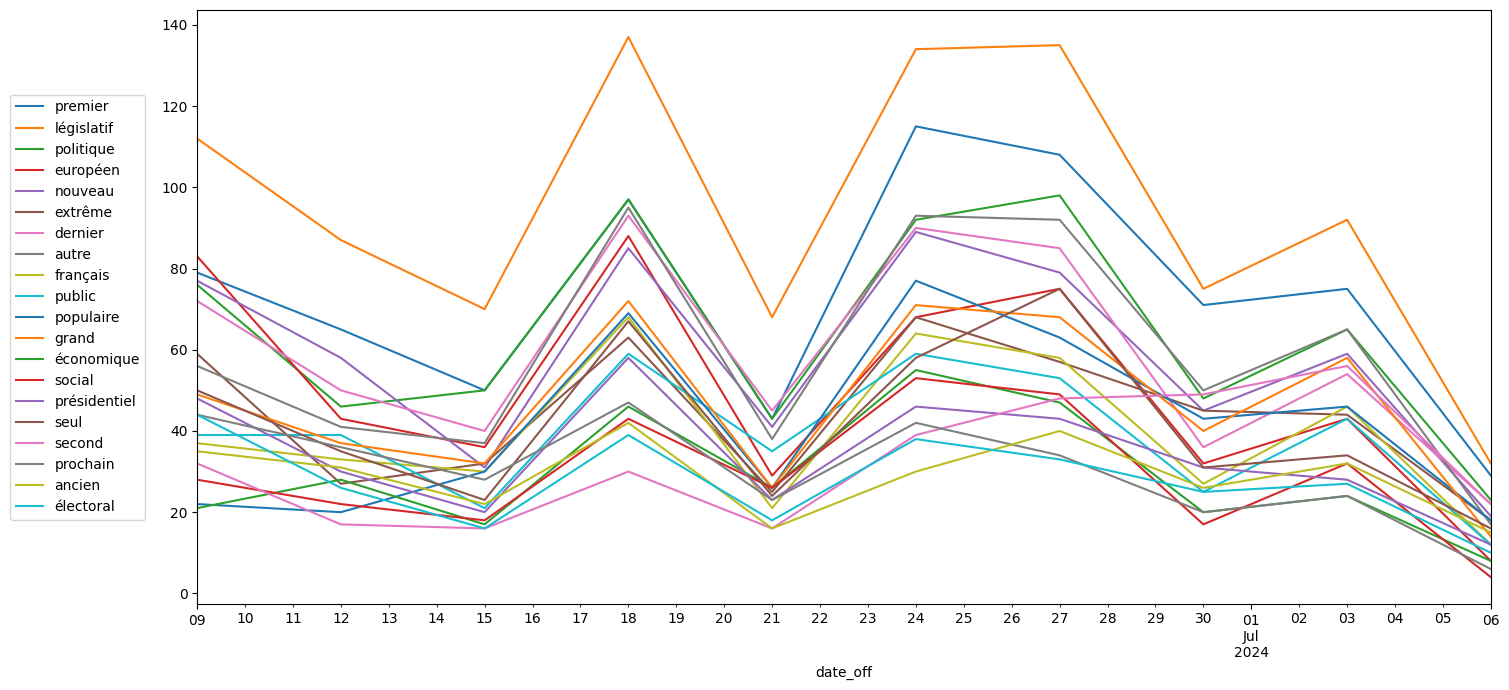

In [219]:
## Sur les adjectifs
df_total_augmented = df_total_augmented.rename(columns={'date': 'date_off'}) # car "date" est rajoutée ensuite en colonne car un nom des expandedLabels...

concat_adjectifs = pd.concat(
    [df_total_augmented[['date_off']].reset_index(drop=True), expandedLabels_adjectives.reset_index(drop=True)],
    axis=1
)

#intermediary = concat_adjectifs.set_index(pd.to_datetime(concat_adjectifs['date_off'])).resample("3D").sum()


intermediary = concat_adjectifs.set_index(
    pd.to_datetime(concat_adjectifs['date_off'], dayfirst=True)
).resample("3D").sum() # au cas où la date est sous le format dd/mm/yyyu

most_common_adj = [i[0] for i in Counter(Adj_list).most_common(20)]

fig, ax = plt.subplots(figsize=(15, 7))  # Crée figure + axe plus grand

intermediary[most_common_adj].plot(ax=ax)
ax.legend(
    loc='center left',     # centré verticalement, à gauche
    bbox_to_anchor=(-0.15, 0.5)  # plus tu diminues -0.15, plus tu écartes la légende vers la gauche
)
plt.tight_layout()

plt.show()

In [ ]:
most_common_nouns = [i[0] for i in Counter(Nouns_list).most_common(20)]
intermediary[most_common_nouns].plot()

### D) Topic analysis

In [58]:
df_centre

,nom_journal,date,contenu,orientation,type_journal
0,ECHOS,10/06/2024,"Page 38 of 48 © 2025 Factiva, Inc. Tous droits...",centre,quotidien
1,ECHOS,10/06/2024,"Page 34 of 48 © 2025 Factiva, Inc. Tous droits...",centre,quotidien
2,ECHOS,10/06/2024,"Page 42 of 48 © 2025 Factiva, Inc. Tous droits...",centre,quotidien
3,ECHOS,10/06/2024,"Page 43 of 48 © 2025 Factiva, Inc. Tous droits...",centre,quotidien
4,ECHOS,10/06/2024,"Page 40 of 48 © 2025 Factiva, Inc. Tous droits...",centre,quotidien
...,...,...,...,...,...
112,TSONL,29/06/2024,. TX Group AG\nTour d'horizon des programmes d...,centre,quotidien
113,TSONL,29/06/2024,. TX Group AG\nAncien ministre des Affaires ét...,centre,quotidien
114,TSONL,30/06/2024,. TX Group AG\nLes électeurs français sont app...,centre,quotidien
115,TSONL,30/06/2024,. TX Group AG\nAprès un revers cuisant aux lég...,centre,quotidien


In [71]:

documents = list(df_total[df_total['type_journal']=='hebdomadaire']['contenu'])

nlp = spacy.load("fr_core_news_sm") # Load the French language model from spaCy, download it if not already done before with !python -m spacy download fr_core_news_sm     on the prompt

In [72]:
## run the pipeline
documents_nlp = []
for d in tqdm(nlp.pipe(documents,n_process=1),total=len(documents)):
    documents_nlp.append(d)
len(documents_nlp) == len(df_total) 



100%|██████████| 419/419 [00:56<00:00,  7.36it/s]


False

In [73]:
## lemmatize!
## remove stopwords



list_nouns_to_delete=['rassemblement',"l’","«","-",'»',"c’","lesechos.fr"]
list_adjectives_to_delete=['tout','national',"c’",'«',"l’","-","b",'quel','xx','*']


def lemmatize(nlpdoc,to_ignore=list_nouns_to_delete+list_adjectives_to_delete): # to_ignore is a list of words to ignore
    lemmalist = []
    for token in nlpdoc:
        if not token.is_stop and token.is_alpha and not token.text in to_ignore: # Check if the token is not a stop word, is alphabetic, and is not in the ignore list
            lemmalist.append(token.lemma_)
    return lemmalist

documents_lemmas = []
for nlpdoc in tqdm(documents_nlp):
    documents_lemmas.append(lemmatize(nlpdoc)) # permet de mettre sous la forme d'une liste de listes de mots

documents_lemmas_lower = []
for doc in documents_lemmas:
    documents_lemmas_lower.append([i.lower() for i in doc]) # pour tout mettre en minsucule


100%|██████████| 419/419 [00:00<00:00, 1829.12it/s]


In [74]:
def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=20, threshold=200) # pour avoir des bigrams comme Machine learning par exemple
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]
documents_lemmas_bigrams = make_bigrams(documents_lemmas_lower)
documents_lemmas_trigrams = make_bigrams(documents_lemmas_bigrams) # pour avoir également des trigrams comme machine learning algorithm par exemple




In [75]:
# Create a dictionary representation of the documents.

dictionary = gensim.corpora.Dictionary(documents_lemmas_trigrams)

# Filter out words that occur in less than 20 documents, or more than 70% of the documents.
dictionary.filter_extremes(no_below=20, no_above=.7)

In [76]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in documents_lemmas_trigrams] # Chaque document (doc) est transformé en liste de tuples (id_mot, nombre_d'occurrences) 
print(f'Number of unique tokens: {len(dictionary)}') #id_mot est l'index du mot dans le dictionnaire
print(f'Number of documents:{len(corpus)}')

Number of unique tokens: 1234
Number of documents:419


In [79]:
%%time
from gensim.models import LdaModel

# Set training parameters. je fais un Latent Dirichlet Allocation pour trouver des sujets
num_topics = 12 # Number of topics to be extracted.
chunksize = len(corpus) # je veux utiliser tous mes articles 
passes = 130
iterations = 130
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel( # crée un modèle
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
#     eval_every=eval_every
)

n_topics = len(lda_model.get_topics()) # permet de vérifier qu'on a bien le bon nombre de topics
print(n_topics) 

12
CPU times: total: 1min 48s
Wall time: 1min 48s


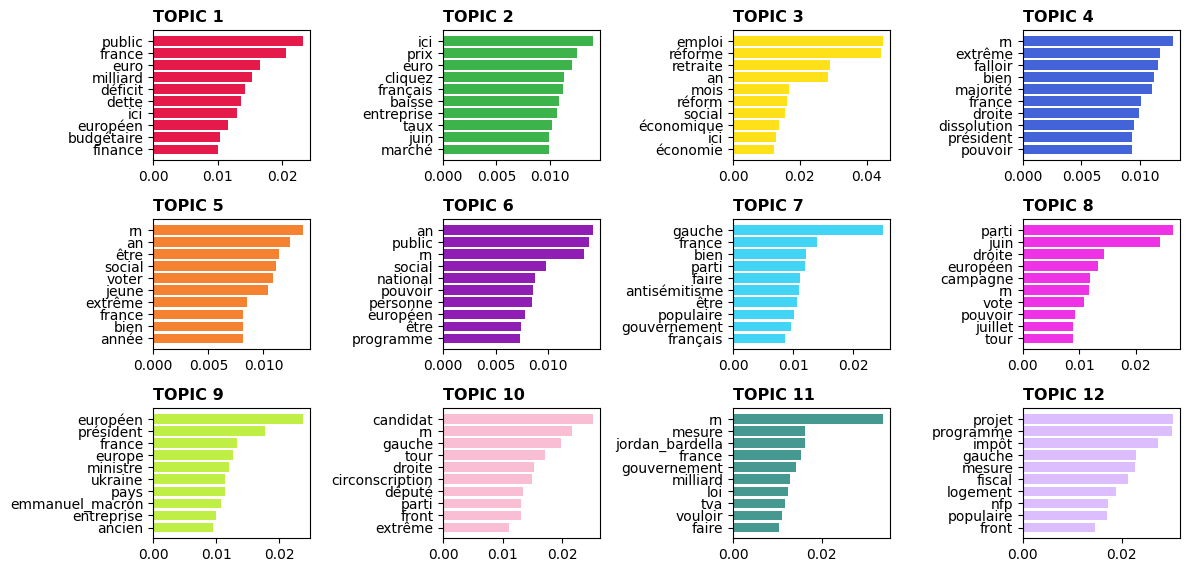

In [81]:
colormap = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9', '#ffffff', '#000000']
colormap = colormap*10

# Affichage 

topicsdict = {"topics": []}
n_topics = len(lda_model.get_topics())
for i in range(n_topics):
    topic = lda_model.get_topic_terms(i)
    wordfreqdict = {}
    for wtuple in topic:
        wordidx = wtuple[0]
        word = id2word[wordidx]
        wordfreqdict[word] = wtuple[1]
    topicsdict["topics"].append(wordfreqdict)

fig = plt.figure(figsize=(12,16))
topslist = topicsdict['topics']
for top_idx in range(num_topics):
    y = ["data" if i=="datum" else i for i in list(topslist[top_idx].keys())[::-1]]
    ax = fig.add_subplot(8,4,top_idx+1)
    ax.set_title(f"TOPIC {top_idx+1}",loc='left',fontdict={'size':11.5,'weight':'bold'})
    ax.barh(y=y,width=list(topslist[top_idx].values())[::-1],color=colormap[top_idx])
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# plt.savefig("plots/topics.pdf",dpi=300,bbox_inches='tight')
plt.show()

### D) Analysis on csv generated

#### Brut comparaison of top nouns and top adjectives

In [213]:
# Comparaison sur les noms entre les trois orientations politiques

df_top_500_centre=pd.read_csv('Top_words/top_500_noms_centre.csv', sep=',', encoding='utf-8')
df_top_500_gauche=pd.read_csv('Top_words/top_500_noms_gauche.csv', sep=',', encoding='utf-8')
df_top_500_droite=pd.read_csv('Top_words/top_500_noms_droite.csv', sep=',', encoding='utf-8')

df_top_500_centre = df_top_500_centre.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_centre = df_top_500_centre.rename(columns={'nom': 'nom_centre', 'count': 'count_centre'})

df_top_500_gauche = df_top_500_gauche.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_gauche = df_top_500_gauche.rename(columns={'nom': 'nom_gauche', 'count': 'count_gauche'})

df_top_500_droite = df_top_500_droite.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_droite = df_top_500_droite.rename(columns={'nom': 'nom_droite', 'count': 'count_droite'})

df_comparaison = pd.concat([df_top_500_centre.reset_index(drop=True),
                            df_top_500_gauche.reset_index(drop=True),
                            df_top_500_droite.reset_index(drop=True)], axis=1)
df_comparaison

df_comparaison.to_csv('Top_words/comparaison_top_500_noms.csv', index=False, encoding='utf-8')

In [214]:
# comparaison sur les adjectifs entre les trois orientations politiques


df_top_500_centre=pd.read_csv('Top_words/top_500_adjectifs_centre.csv', sep=',', encoding='utf-8')
df_top_500_gauche=pd.read_csv('Top_words/top_500_adjectifs_gauche.csv', sep=',', encoding='utf-8')
df_top_500_droite=pd.read_csv('Top_words/top_500_adjectifs_droite.csv', sep=',', encoding='utf-8')

df_top_500_centre = df_top_500_centre.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_centre = df_top_500_centre.rename(columns={'nom': 'nom_centre', 'count': 'count_centre'})

df_top_500_gauche = df_top_500_gauche.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_gauche = df_top_500_gauche.rename(columns={'nom': 'nom_gauche', 'count': 'count_gauche'})

df_top_500_droite = df_top_500_droite.sort_values(by='count', ascending=False).reset_index(drop=True)
df_top_500_droite = df_top_500_droite.rename(columns={'nom': 'nom_droite', 'count': 'count_droite'})

df_comparaison = pd.concat([df_top_500_centre.reset_index(drop=True),
                            df_top_500_gauche.reset_index(drop=True),
                            df_top_500_droite.reset_index(drop=True)], axis=1)
df_comparaison

df_comparaison.to_csv('Top_words/comparaison_top_500_adjectifs.csv', index=False, encoding='utf-8')

### E) Exploitation of classified CSV top 500

#### E.1 Calculating IB and HR scores

In [4]:
df_adjectifs_classified = pd.read_csv('Top_words/comparaison_top_500_adjectifs_classified.csv', sep=',', encoding='utf-8')
df_nouns_classified = pd.read_csv('Top_words/comparaison_top_500_noms_classified.csv', sep=',', encoding='utf-8') 

# supperpose les colonnes de chaque df

# Sélectionner chaque groupe de colonnes
df1 = df_adjectifs_classified.iloc[:, [0,1,2]]
df2 = df_adjectifs_classified.iloc[:, [3,4,5]]
df3 = df_adjectifs_classified.iloc[:, [6,7,8]]

# Renommer les colonnes
df1.columns = ['adjectif', 'count', 'orientation']
df2.columns = ['adjectif', 'count', 'orientation']
df3.columns = ['adjectif', 'count', 'orientation']

# Concaténer verticalement
df_adjectifs_classified_all = pd.concat([df1, df2, df3], ignore_index=True)

# transfomer en dictionnaire 

dico_adjectifs_orientation = dict(zip(df_adjectifs_classified_all['adjectif'],df_adjectifs_classified_all['orientation']))

# Sélectionner chaque groupe de colonnes
df1 = df_nouns_classified.iloc[:, [0,1,2]]
df2 = df_nouns_classified.iloc[:, [3,4,5]]
df3 = df_nouns_classified.iloc[:, [6,7,8]]

# Renommer les colonnes
df1.columns = ['nom', 'count', 'orientation']
df2.columns = ['nom', 'count', 'orientation']
df3.columns = ['nom', 'count', 'orientation']

# Concaténer verticalement
df_nouns_classified_all = pd.concat([df1, df2, df3], ignore_index=True)

# Transformer en dictionnaire
dico_noms_orientation = dict(zip(df_nouns_classified_all['nom'], df_nouns_classified_all['orientation']))

# Some post-treatment needed in dico-adjectives because of redaction errors

for key in dico_adjectifs_orientation:
    if dico_adjectifs_orientation[key]=='IB ' or dico_adjectifs_orientation[key]=='I'or dico_adjectifs_orientation[key]=='I ':
        dico_adjectifs_orientation[key]='IB' #une seule notation
    if dico_adjectifs_orientation[key]=='H' or dico_adjectifs_orientation[key]=='HR ' : # faute de frappes
        dico_adjectifs_orientation[key]='HR'
    if dico_adjectifs_orientation[key]=='nan' or dico_adjectifs_orientation[key]=='N ' or dico_adjectifs_orientation[key]==' nan' : # faute de frappes
        dico_adjectifs_orientation[key]='N'


In [ ]:
print('HR nouns mean frequency => ', df_nouns_classified_all[df_nouns_classified_all['orientation'] == 'HR'].head(400)['count'].mean())
print('IB nouns mean frequency => ', df_nouns_classified_all[df_nouns_classified_all['orientation'] == 'IB'].head(400)['count'].mean())
print('HR adjectives mean frequency => ', df_adjectifs_classified_all[df_adjectifs_classified_all['orientation'] == 'HR'].head(400)['count'].mean())
print('IB adjectives mean frequency => ', df_adjectifs_classified_all[df_adjectifs_classified_all['orientation'] == 'IB'].head(400)['count'].mean())

# noms HR apparaissent 171/90 fois plus que IB et HR adjectifs 57/30 fois plus que IB adjectives => homogénéise ensuite

# En moyenne fréquence d'un terme global classifié HR 171+57/30+90 = 228 / 120



HR nouns mean frequency =>  171.7725321888412
IB nouns mean frequency =>  90.10689655172413
HR adjectives mean frequency =>  57.772946859903385
IB adjectives mean frequency =>  30.753246753246753


In [ ]:
## Quelques chiffres sur les dictionnaires
from collections import Counter
compte_valeurs_noms = Counter(dico_noms_orientation.values())
compte_valeurs_adjectifs = Counter(dico_adjectifs_orientation.values())
# Affichage propre

print("Répartition pour les noms")
for orientation, count in compte_valeurs_noms.items():
    print(f"{orientation}: {count} keys") # 142 noms IB et 101 noms HR

print("Répartition pour les adjectifs")
for orientation, count in compte_valeurs_adjectifs.items():
    print(f"{orientation}: {count} keys") # 222 adjectifs IB et 97 adjectifs HR

# Donc au total 222+142 soit 364 indicateurs IB et 198 indicateurs HR => faut-il uniformiser ensuite  ??? FAIT EN TOUS CAS


Répartition pour les noms
HR: 101 keys
N: 463 keys
IB: 142 keys
Répartition pour les adjectifs
HR: 99 keys
IB: 222 keys
N: 434 keys
nan: 35 keys


In [7]:
# tokenize pour avoir un dataset analysable 

df_to_treat=0

def return_nouns_verbs_adjectives(nlpdoc): # fonction pour lemmatiser et tokeniser les documents
    ## define a nounlist
    l_noun = []
    l_adjectives=[]
    l_verbs=[]
    for token in nlpdoc:
        if token.pos_ == 'NOUN':
             l_noun.append(token.lemma_)
        if token.pos_ == 'ADJ':
            l_adjectives.append(token.lemma_)
        if token.pos_ == 'VERB':
            l_verbs.append(token.lemma_)
    return l_noun, l_adjectives, l_verbs



In [8]:

def generate_IB_HR_df(df_to_treat,dico_noms_orientation=dico_noms_orientation,dico_adjectifs_orientation=dico_noms_orientation): # fonction pour générer le dataframe avec les scores HR et IB



    df_to_treat["l_nouns_IB"] = None  # Initialisation correcte
    df_to_treat["l_nouns_HR"] = None
    df_to_treat["l_adjectifs_IB"] = None
    df_to_treat["l_adjectifs_HR"] = None
    
    df_to_treat["score_HR_nouns"] = None
    df_to_treat["score_IB_nouns"] = None
    df_to_treat["score_HR_adjectifs"] = None
    df_to_treat["score_IB_adjectifs"] = None
    df_to_treat["score_HR_global"] = None
    df_to_treat["score_IB_global"] = None

    df_to_treat = df_to_treat.reset_index(drop=True)


    nlp = spacy.load("fr_core_news_sm") # instanciation de spacy pour le français
    documents_nlp = []

    for d in tqdm(nlp.pipe(df_to_treat["contenu"],n_process=1),total=len(df_to_treat["contenu"])): # tokenize tout le contenu
        documents_nlp.append(d)
    len(documents_nlp) == len(df_to_treat) 


    for idx_line in range(len(df_to_treat)): # on parcourt le dataset article par article et on fait le traitement suivant pour chaque
        
        l_adj_IB,l_adj_HR=[],[] # variables par article pour stocker les adjectifs reconnus, je mets 'NaN' pour au moins qu'il y ait une valeur dans la liste
        l_nouns_IB,l_nouns_HR=[],[] # variables par article pour stocker les noms reconnus

        content=df_to_treat.iloc[idx_line]['contenu'] # on prend le contenu de la ligne
        nlpcontent= doc = nlp(content) # on le tokenise
        Nouns, adjectives, verbs = return_nouns_verbs_adjectives(nlpcontent) # on lemmatise et tokenise pour les mots dans le contenu

        # on parcours Nouns pour voir si un est dans le dico dico_noms_orientation qui permet de classer entre HR et IB
        for noun in Nouns:
            if noun in dico_noms_orientation and dico_noms_orientation[noun] == 'IB':
                l_nouns_IB.append(noun)
            if noun in dico_noms_orientation and dico_noms_orientation[noun] == 'HR':
                l_nouns_HR.append(noun)

        # on parcours adjectives pour voir si un est dans le dico dico_adjectifs_orientation qui permet de classer entre HR et IB

        for adjectif in adjectives:
            if adjectif in dico_adjectifs_orientation and dico_adjectifs_orientation[adjectif] == 'IB' :
                l_adj_IB.append(adjectif)
                if len(adjectif)<3:
                    print(adjectif,dico_adjectifs_orientation[adjectif])
            if adjectif in dico_adjectifs_orientation and dico_adjectifs_orientation[adjectif] == 'HR':
                l_adj_HR.append(adjectif)
                if len(adjectif)<3:
                    print(adjectif,dico_adjectifs_orientation[adjectif])
        
        # On normaliste par le nombre de mots dans l'article mais aussi par rapport à la différence entre le nombre d'objets classés IB et HR/
        # et par rapport au nombre d'occurences naturelles de termes HR et IB


        score_HR_nouns=(len(l_nouns_HR)/len(nlpcontent))*142/101 # on calcule le score HR  NORMALISE par rapport au nombre de mots dans l'article
        score_IB_nouns=(len(l_nouns_IB)/len(nlpcontent))*171/90 # on calcule le score IB NORMALISE
        score_HR_adjectifs=(len(l_adj_HR)/len(nlpcontent))*222/97 # on calcule le score HR NORMALISE
        score_IB_adjectifs=(len(l_adj_IB)/len(nlpcontent))*57/30 # on calcule le score IB NORMALISE 
        score_HR_global=(score_HR_nouns+score_HR_adjectifs) # on calcule le score HR global NORMALISE
        score_IB_global=(score_IB_nouns+score_IB_adjectifs) # on calcule le score IB global NORMALISE

        # on remplit les colonnes du dataframe avec les scores et les listes de mots, les scores sont normalisées 
        #print(l_nouns_IB)
        df_to_treat.at[idx_line, "l_nouns_IB"] = l_nouns_IB
        df_to_treat.at[idx_line, "l_nouns_HR"] = l_nouns_HR
        df_to_treat.at[idx_line, "l_adjectifs_IB"] = l_adj_IB
        df_to_treat.at[idx_line, "l_adjectifs_HR"] = l_adj_HR
        df_to_treat.at[idx_line, "score_HR_nouns"] = score_HR_nouns
        df_to_treat.at[idx_line, "score_IB_nouns"] = score_IB_nouns 
        df_to_treat.at[idx_line, "score_HR_adjectifs"] = score_HR_adjectifs
        df_to_treat.at[idx_line, "score_IB_adjectifs"] = score_IB_adjectifs 
        df_to_treat.at[idx_line, "score_HR_global"] = score_HR_global 
        df_to_treat.at[idx_line, "score_IB_global"] = score_IB_global 


    return df_to_treat # on retourne le dataframe avec les scores et les listes de mots
    
        

In [13]:
df_centre_IB_HR = generate_IB_HR_df(df_centre)
df_centre_IB_HR.to_csv('IB_or_HR/df_centre_IB_HR_ranked.csv', index=False, encoding='utf-8')

100%|██████████| 679/679 [01:25<00:00,  7.97it/s]


In [10]:
from itertools import chain
print([s for s in chain.from_iterable(df_gauche_IB_HR['l_adjectifs_HR']) if len(s) < 3]) # tous les datasets sont cleans à ce stade

[]


#### E.2 Graphs of IB/HR scores

In [14]:
df_centre_IB_HR = pd.read_csv('IB_or_HR/df_centre_IB_HR_ranked.csv', sep=',', encoding='utf-8') # réimporte les dataframes générés plus haut, permet de ne pas relancer le code à chaque fois
df_gauche_IB_HR = pd.read_csv('IB_or_HR/df_gauche_IB_HR_ranked.csv', sep=',', encoding='utf-8')
df_droite_IB_HR = pd.read_csv('IB_or_HR/df_droite_IB_HR_ranked.csv', sep=',', encoding='utf-8')

In [ ]:
df_centre_IB_HR

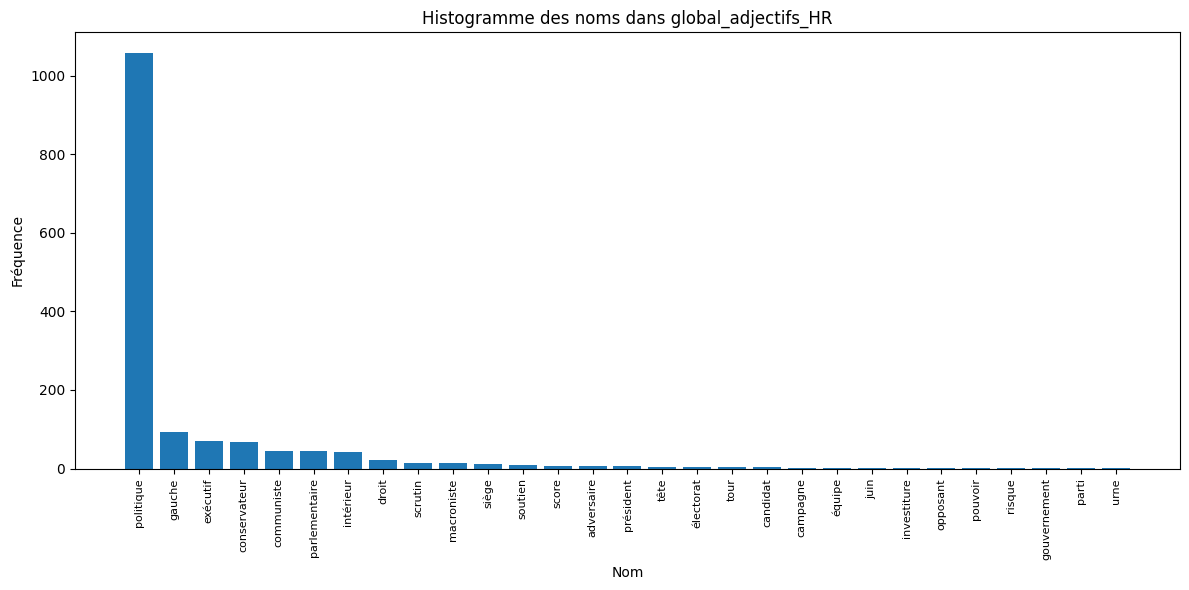

In [26]:
import ast

global_nouns_IB=[]
for list in df_centre_IB_HR['l_adjectifs_HR'] :
    list=ast.literal_eval(list)
    global_nouns_IB.extend(list) # on concatène les listes de noms extraits pour chaque article
for list in df_gauche_IB_HR['l_adjectifs_HR'] :
    global_nouns_IB.extend(list) # on concatène les listes de noms extraits pour chaque article
for list in df_droite_IB_HR['l_adjectifs_HR'] :
    global_nouns_IB.extend(list) # on concatène les listes de noms extraits pour chaque article


global_nouns_IB= [k for k in global_nouns_IB if len(k) > 3] # tous les datasets sont cleans à ce stade

import matplotlib.pyplot as plt
from collections import Counter


# Compter les occurrences de chaque nom
counter = Counter(global_nouns_IB)

# Optionnel : trier les noms par fréquence décroissante
most_common = counter.most_common()

# Séparer noms et fréquences
noms, freqs = zip(*most_common)

# Tracer l'histogramme
plt.figure(figsize=(12, 6))
plt.bar(noms, freqs)
plt.xticks(rotation=90, fontsize=8)  # taille de la police réduite ici
plt.title("Histogramme des noms dans global_adjectifs_HR")
plt.xlabel("Nom")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()


In [27]:
def generate_scores_journaliers(df_to_treat, nb_days=5):
    """
    Calcule les moyennes des scores globaux par blocs de nb_days jours.
    """
    cols_scores = ["contenu","score_HR_global", "score_IB_global"]
    
    # Convertir la colonne 'date' en datetime si ce n'est pas déjà fait
    df_to_treat["date"] = pd.to_datetime(df_to_treat["date"], format="%d/%m/%Y")
    
    # Créer une nouvelle colonne pour grouper les dates par lots de nb_days
    min_date = df_to_treat["date"].min()
    df_to_treat["date_group"] = ((df_to_treat["date"] - min_date).dt.days // nb_days) * nb_days
    df_to_treat["date_group"] = min_date + pd.to_timedelta(df_to_treat["date_group"], unit='D')

    # Groupby sur cette nouvelle colonne
    df_scores_grouped = (
        df_to_treat
        .groupby("date_group", as_index=False)[cols_scores]
        .mean()
        .rename(columns={"date_group": "date"})
    )

    return df_scores_grouped

In [28]:
scores_journaliers_droite=generate_scores_journaliers(df_droite_IB_HR)
scores_journaliers_gauche=generate_scores_journaliers(df_gauche_IB_HR)
scores_journaliers_centre=generate_scores_journaliers(df_centre_IB_HR)


# Ajouter des suffixes à chaque DataFrame
scores_journaliers_droite = scores_journaliers_droite.add_suffix('_droite')
scores_journaliers_gauche = scores_journaliers_gauche.add_suffix('_gauche')
scores_journaliers_centre = scores_journaliers_centre.add_suffix('_centre')




# Concatenation des DataFrames avec les suffixes
scores_journaliers_comparaison = pd.concat([scores_journaliers_droite.reset_index(drop=True),
                                             scores_journaliers_gauche.reset_index(drop=True),
                                             scores_journaliers_centre.reset_index(drop=True)], axis=1)

# Supprimer les colonnes 'date_centre' et 'date_gauche'
scores_journaliers_comparaison = scores_journaliers_comparaison.drop(columns=['date_centre', 'date_gauche'])

# Renommer la colonne 'date_droite' en 'date'
scores_journaliers_comparaison = scores_journaliers_comparaison.rename(columns={'date_droite': 'date'})

scores_journaliers_comparaison # permet d'avoir un dataframe concaténer pour pouvoir faire des comparaisons entre les trois orientations politiques

# Calculer des rations

scores_journaliers_comparaison['ratio_HR/IB_gauche']=scores_journaliers_comparaison['score_HR_global_gauche']/scores_journaliers_comparaison['score_IB_global_gauche']
scores_journaliers_comparaison['ratio_HR/IB_droite']=scores_journaliers_comparaison['score_HR_global_droite']/scores_journaliers_comparaison['score_IB_global_droite']
scores_journaliers_comparaison['ratio_HR/IB_centre']=scores_journaliers_comparaison['score_HR_global_centre']/scores_journaliers_comparaison['score_IB_global_centre']



scores_journaliers_comparaison

C:\Users\ridea\AppData\Local\Temp\ipykernel_8840\3473631853.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
C:\Users\ridea\AppData\Local\Temp\ipykernel_8840\3473631853.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()
C:\Users\ridea\AppData\Local\Temp\ipykernel_8840\3473631853.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


,date,score_HR_global_droite,score_IB_global_droite,score_HR_global_gauche,score_IB_global_gauche,score_HR_global_centre,score_IB_global_centre,ratio_HR/IB_gauche,ratio_HR/IB_droite,ratio_HR/IB_centre
0,2024-06-10,0.070813,0.038509,0.076642,0.036205,0.077815,0.050713,2.116915,1.838881,1.534416
1,2024-06-15,0.062838,0.042755,0.074616,0.061268,0.071604,0.050402,1.217865,1.469705,1.420649
2,2024-06-20,0.057894,0.039899,0.065316,0.043286,0.059958,0.056203,1.508946,1.451013,1.066813
3,2024-06-25,0.061152,0.036902,0.062319,0.039468,0.061817,0.057814,1.578990,1.657121,1.069241
4,2024-06-30,0.065934,0.040623,0.067151,0.030006,0.079112,0.043836,2.237956,1.623078,1.804729
5,2024-07-05,0.065362,0.042925,0.053915,0.035570,0.073471,0.041758,1.515752,1.522703,1.759466


In [29]:
### Quelques calculs de moyennes
# Calculer la moyenne pour chaque colonne
means = scores_journaliers_comparaison.mean()

# Affichage propre en anglais
print("Average scores:")
print(f"Average Horse Race Global Score (Right): {means['score_HR_global_droite']:.4f}")
print(f"Average Issue-Based Global Score (Right): {means['score_IB_global_droite']:.4f}")
print(f"Average Horse Race Global Score (Left): {means['score_HR_global_gauche']:.4f}")
print(f"Average Issue-Based Global Score (Left): {means['score_IB_global_gauche']:.4f}")
print(f"Average Horse Race Global Score (Center): {means['score_HR_global_centre']:.4f}")
print(f"Average Issue-Based Global Score (Center): {means['score_IB_global_centre']:.4f}")
print(f"Average HR/IB ratio (Left): {means['ratio_HR/IB_gauche']:.4f}")
print(f"Average HR/IB ratio Race Global Score (Center): {means['ratio_HR/IB_centre']:.4f}")
print(f"Average HR/IB ratio (Center): {means['ratio_HR/IB_droite']:.4f}")



Average scores:
Average Horse Race Global Score (Right): 0.0640
Average Issue-Based Global Score (Right): 0.0403
Average Horse Race Global Score (Left): 0.0667
Average Issue-Based Global Score (Left): 0.0410
Average Horse Race Global Score (Center): 0.0706
Average Issue-Based Global Score (Center): 0.0501
Average HR/IB ratio (Left): 1.6961
Average HR/IB ratio Race Global Score (Center): 1.4426
Average HR/IB ratio (Center): 1.5938


C:\Users\ridea\AppData\Local\Temp\ipykernel_8840\2964256633.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  means = scores_journaliers_comparaison.mean()


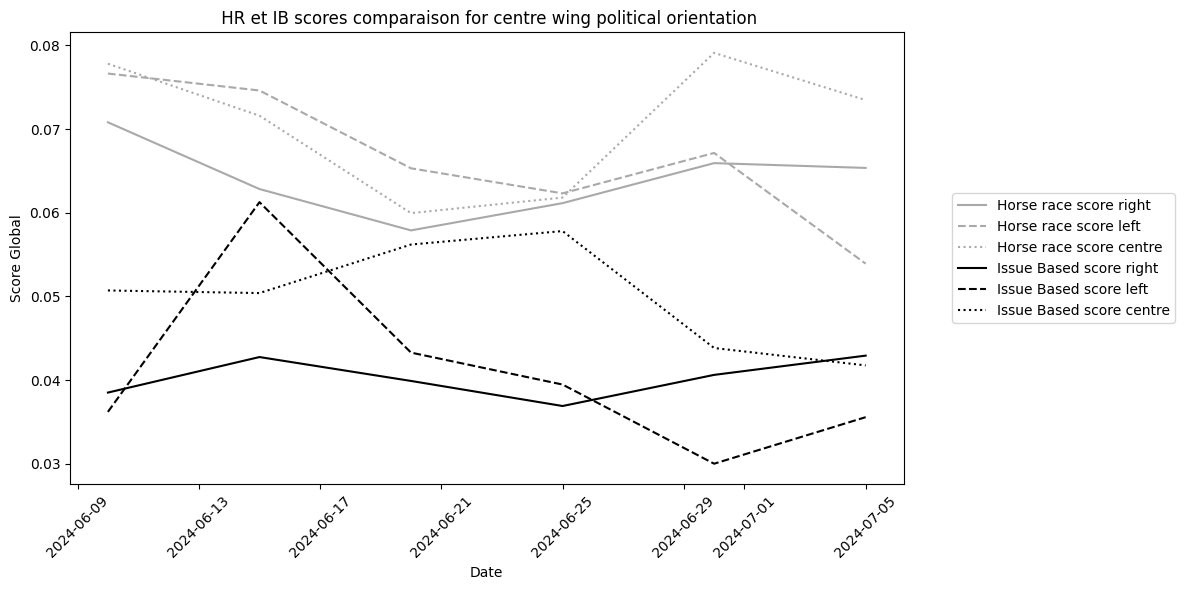

In [32]:
# plot 


def plot_scores_comparison(df):
    # Configurer la taille de la figure
    plt.figure(figsize=(12, 6))
    
    # Tracer les courbes pour score_HR_global avec différentes orientations
    sns.lineplot(x='date', y='score_HR_global_droite', data=df, label='Horse race score right', color='#A9A9A9', linestyle='-')
    sns.lineplot(x='date', y='score_HR_global_gauche', data=df, label='Horse race score left', color='#A9A9A9', linestyle='--')
    sns.lineplot(x='date', y='score_HR_global_centre', data=df, label='Horse race score centre ', color='#A9A9A9', linestyle=':')

    # Tracer les courbes pour score_IB_global avec différentes orientations
    sns.lineplot(x='date', y='score_IB_global_droite', data=df, label='Issue Based score right', color='black', linestyle='-')
    sns.lineplot(x='date', y='score_IB_global_gauche', data=df, label='Issue Based score left', color='black', linestyle='--')
    sns.lineplot(x='date', y='score_IB_global_centre', data=df, label='Issue Based score centre', color='black', linestyle=':')

    # Ajouter un titre et des labels
    plt.title(' HR et IB scores comparaison for centre wing political orientation')
    plt.xlabel('Date')
    plt.ylabel('Score Global')

    # Rotation des dates pour plus de lisibilité
    plt.xticks(rotation=45)

    

    # Affichage de la légende
    plt.legend()
    plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left') # intégrer le nombre d'articles total ce jour là ?? 

    # Affichage du graphique
    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction avec ton DataFrame
plot_scores_comparison(scores_journaliers_comparaison)



#### E.3 Graphs by rythm of parution

In [33]:
df_centre_IB_HR = pd.read_csv('IB_or_HR/df_centre_IB_HR_ranked.csv', sep=',', encoding='utf-8') # réimporte les dataframes générés plus haut, permet de ne pas relancer le code à chaque fois
df_gauche_IB_HR = pd.read_csv('IB_or_HR/df_gauche_IB_HR_ranked.csv', sep=',', encoding='utf-8')
df_droite_IB_HR = pd.read_csv('IB_or_HR/df_droite_IB_HR_ranked.csv', sep=',', encoding='utf-8')

df_combined = pd.concat([df_centre_IB_HR, df_gauche_IB_HR, df_droite_IB_HR], axis=0).reset_index(drop=True)


In [34]:
colonnes_scores = [
    'score_HR_nouns',
    'score_IB_nouns',
    'score_HR_adjectifs',
    'score_IB_adjectifs',
    'score_HR_global',
    'score_IB_global'
]

# Groupement par média et date, puis moyenne

df_moyennes_daily = df_combined.groupby(['nom_journal', 'date'])[colonnes_scores].mean().reset_index()
# Assurer que la colonne 'date' est en format datetime
df_moyennes_daily['date'] = pd.to_datetime(df_moyennes_daily['date'], format='%d/%m/%Y')

# Créer une colonne 'semaine' pour chaque ligne, basé sur la date
df_moyennes_daily['semaine'] = df_moyennes_daily['date'].dt.isocalendar().week

# Regrouper par 'nom_journal' et 'semaine', puis calculer la moyenne
df_moyennes_semaine = df_moyennes_daily.groupby(['nom_journal', 'semaine'])[colonnes_scores].mean().reset_index()

# Afficher le résultat pour vérifier


In [36]:
# pour calculer les ratios par type de média

# Ajouter la colonne 'journal_type' basée sur le dictionnaire
journal_type = {
    'ECHOS': 'quotidien', #quotidien de droite
    'EXPRSS': 'hebdomadaire',  # L'Express est un hebdomadaire
    'FIGARO': 'quotidien', #quotidien de droite
    'HUMAN': 'quotidien', #quotidien de gauche
    'LACRX': 'hebdomadaire', # hebdomadaire du centre
    'LBRT': 'quotidien', #quotidien de gauche
    'LENOV': 'hebdomadaire', #hebdomadaire de gauche
    'LPOINT': 'hebdomadaire', #hebdomadaire de droite
    'MARIAN': 'hebdomadaire', # hebdomadaire de gauche 
    'TRDS': 'hebdomadaire', # la tribune hebdo du centre
    'TSONL': 'quotidien'# quoditien du centre
}


# Ajouter la colonne 'journal_type' à df_combined
df_combined['journal_type'] = df_combined['nom_journal'].map(journal_type)

df_combined = df_combined[df_combined['score_IB_global'] != 0]

# Calculer le ratio HR_global/IB_global pour chaque ligne
df_combined['ratio'] = df_combined['score_HR_global'] / df_combined['score_IB_global']

# Calculer le ratio moyen pour chaque type de média (quotidien vs hebdomadaire)

df_combined_daily= df_combined[df_combined['journal_type'] == 'quotidien']
df_combined_weekly= df_combined[df_combined['journal_type'] == 'hebdomadaire']

print ('Ratio moyen pour les quotidiens :', df_combined_daily['ratio'].mean())
print ('Ratio moyen pour les hebdomadaires :', df_combined_weekly['ratio'].mean())

Ratio moyen pour les quotidiens : 2.56389815070048
Ratio moyen pour les hebdomadaires : 2.23581264603982


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de données (à remplacer par ton DataFrame df_moyennes_semaine)
# df_moyennes_semaine = pd.read_csv('ton_fichier.csv')

# Assurer que les colonnes nécessaires sont bien des numériques
df_moyennes_semaine['score_HR_global'] = pd.to_numeric(df_moyennes_semaine['score_HR_global'], errors='coerce')
df_moyennes_semaine['score_IB_global'] = pd.to_numeric(df_moyennes_semaine['score_IB_global'], errors='coerce')

# Remplacer les NaN par 0 ou une autre valeur (selon ta préférence)
df_moyennes_semaine = df_moyennes_semaine.fillna(0)

# S'assurer que la colonne semaine est bien d'un type numérique et sans NaN
df_moyennes_semaine['semaine'] = pd.to_numeric(df_moyennes_semaine['semaine'], errors='coerce')
df_moyennes_semaine['semaine'].fillna(0, inplace=True)

# Récupérer les médias uniques
medias = df_moyennes_semaine['nom_journal'].unique()

# Boucle pour afficher un graphique pour chaque média
for media in medias:
    # Filtrer les données pour le média courant
    df_media = df_moyennes_semaine[df_moyennes_semaine['nom_journal'] == media]
    
    # Créer un graphique
    plt.figure(figsize=(10, 6))
    
    # Ploter les bar charts pour score_HR_global et score_IB_global
    bar_width = 0.35
    index = df_media['semaine']

    # Assurer que l'index (semaine) est de type entier
    index = index.astype(int)

    # Ploter les scores
    plt.bar(index - bar_width / 2, df_media['score_HR_global'], bar_width, label='score_HR_global')
    plt.bar(index + bar_width / 2, df_media['score_IB_global'], bar_width, label='score_IB_global')


    # Ajouter les titres et labels
    plt.title(f'Moyennes hebdomadaires pour {media}')
    plt.xlabel('Semaine')
    plt.ylabel('Score')
    plt.xticks(index)  # Ajouter les numéros de semaine sur l'axe des x
    plt.legend()

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


In [ ]:
for media in medias:
    # Filtrer les données pour le média courant
    df_media = df_moyennes_semaine[df_moyennes_semaine['nom_journal'] == media]
    
    # Afficher les résultats
    print(f"Résultats hebdomadaires pour {media} :")
    for semaine in df_media['semaine'].unique():
        semaine_data = df_media[df_media['semaine'] == semaine]
        avg_score_HR_global = semaine_data['score_HR_global'].mean()
        avg_score_IB_global = semaine_data['score_IB_global'].mean()
        
        print(f"Semaine {semaine}:")
        print(f"  Moyenne score_HR_global: {avg_score_HR_global:.4f}")
        print(f"  Moyenne score_IB_global: {avg_score_IB_global:.4f}")
    print("\n" + "-"*50 + "\n")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de données (à remplacer par ton DataFrame df_moyennes_semaine)
# df_moyennes_semaine = pd.read_csv('ton_fichier.csv')

# Assurer que les colonnes nécessaires sont bien des numériques
df_moyennes_semaine['score_HR_global'] = pd.to_numeric(df_moyennes_semaine['score_HR_global'], errors='coerce')
df_moyennes_semaine['score_IB_global'] = pd.to_numeric(df_moyennes_semaine['score_IB_global'], errors='coerce')

# Remplacer les NaN par 0 ou une autre valeur (selon ta préférence)
df_moyennes_semaine = df_moyennes_semaine.fillna(0)

# S'assurer que la colonne semaine est bien d'un type numérique et sans NaN
df_moyennes_semaine['semaine'] = pd.to_numeric(df_moyennes_semaine['semaine'], errors='coerce')
df_moyennes_semaine['semaine'].fillna(0, inplace=True)

# Calcul du ratio score_HR_global / score_IB_global
df_moyennes_semaine['ratio'] = df_moyennes_semaine['score_HR_global'] / df_moyennes_semaine['score_IB_global']

# Récupérer les médias uniques
medias = df_moyennes_semaine['nom_journal'].unique()

# Boucle pour afficher un graphique pour chaque média
for media in medias:
    # Filtrer les données pour le média courant
    df_media = df_moyennes_semaine[df_moyennes_semaine['nom_journal'] == media]
    
    # Créer un graphique plus petit
    plt.figure(figsize=(8, 5))  # Ajuster la taille de la figure

    # Ploter les ratios en gris avec des colonnes plus fines
    index = df_media['semaine'].astype(int)  # S'assurer que l'index (semaine) est de type entier
    bar_width = 0.2  # Colonnes plus fines
    plt.bar(index, df_media['ratio'], width=bar_width, color='gray', label=f'Ratio score_HR_global / score_IB_global')

    # Ajouter les titres et labels
    plt.title(f'Ratio hebdomadaire pour {media}')
    plt.xlabel('Semaine')
    plt.ylabel('Ratio (score_HR_global / score_IB_global)')
    plt.xticks(index)  # Ajouter les numéros de semaine sur l'axe des x
    plt.legend()

    # Afficher le graphique
    plt.tight_layout()
    plt.show()
